**The Relationship between Bank Term Subscriptions, Age and Bank Balance**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in library(themis): there is no package called ‘themis’


**Introduction**<br/>
The Bank Marketing dataset was gathered from a direct marketing campaign of a Portuguese baking institution. The bank collected information from their clients over the phone, and each client was contacted multiple times. The Bank Marketing Dataset discusses multiple characteristics of each client of a bank in hopes to predict whether they will subscribe to a term deposit. In simplest terms, a bank term deposit is depositing a certain sum of money and keeping it in the bank for a specific period of time. The information collected in the dataset includes age, job, education, marital status, balance, education, and housing to name a few.

The question our project aims to answer is: Will new clients subscribe or not subscribe to a bank term deposit? A K-nearest classifier was built to answer this question.


**Methods**<br/>
A preliminary data analysis was completed to review the information, available to us, to work with as well as choose the main predictors to use for the project. The two predictors chosen for the project were age and balance. 

The dataset was first loaded into R from an external website and converted into a .csv file format to ensure that it can be worked with efficiently. The functions head and tail were used to show snippets of the dataset to ensure readability. The select function was then used on the bank dataset to extract the columns we are interested in working with: age, balance and y. The data was then split using the function inital_split. The training set (bank_train) and testing (bank_test) were created to be used for training and testing respectively.
We then created a scatter plot of the unscaled age and and balance. Red and blue data points were used to denote whether or not someone subscribed to a bank term deposit. This was done as part of our initial exploratory analysis.

**Table 1.0 - Bank Data**

 We load the data from source website. It was zip file. So we upzip first before read data. After that, we read the data as csv and treat the variable "y(whether client subscribe to term deposit)" as factor.


In [2]:
temp <- tempfile()
temp2 <- tempfile()

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)

bank_data <- read_csv2(file.path(temp2, "bank.csv")) %>%
    mutate(y = as_factor(y))
unlink(c(temp, temp2))
head(bank_data)
tail(bank_data)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  age = col_double(),
  job = col_character(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  balance = col_double(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  day = col_double(),
  month = col_character(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  y = col_character()
)



age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
32,services,single,secondary,no,473,yes,no,cellular,7,jul,624,5,-1,0,unknown,no
33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


**Table 1.1 - Selected Columns of Bank Data**

 From the original bank dataset, we extract a data frame with only the columns we are interested in which is age and balance. We choose those two variables since we assume that age and balance will effect on client subscription to term deposit. For example, older people may tend to subscribe more than young people or people who has more balance in bank account want more to subscribe to term deposit than less balance. 
 
We want to see some data of bank_age_balance. So we print the head and tail.




In [3]:
bank_age_balance <- bank_data %>% select(age,balance,y)

head(bank_age_balance)
tail(bank_age_balance)

age,balance,y
<dbl>,<dbl>,<fct>
30,1787,no
33,4789,no
35,1350,no
30,1476,no
59,0,no
35,747,no


age,balance,y
<dbl>,<dbl>,<fct>
32,473,no
33,-333,no
57,-3313,no
57,295,no
28,1137,no
44,1136,no


**Table 2.0 - Split of Data**

 We will use 75% of the data for training, and 25% for testing since we don't want to too small for training data and also testing on the accuracy of our model is important as well. We will specify that prop = 0.75 so that 75% of our original data set ends up in the training set. We will set the strata argument to y to ensure that the training and testing subsets contain the right proportions of each category of observation. 
 
  However, we also think that the testing on the accuracy of our model is important, so we believe that 0.75 is an appropriate choise.

In [4]:
# Splitting the data into training data and testing data
bank_split <- initial_split(bank_age_balance, prop = 0.75, strata = y)  
bank_train <- training(bank_split)   
bank_test <- testing(bank_split)

head(bank_train)
tail(bank_test)

age,balance,y
<dbl>,<dbl>,<fct>
30,1787,no
35,1350,no
59,0,no
35,747,no
36,307,no
39,147,no


age,balance,y
<dbl>,<dbl>,<fct>
42,1080,yes
32,620,yes
42,-166,no
36,566,no
33,-333,no
28,1137,no


First, we plot to see how it looks like. We use age for x-axis, balance for y-axis and color on y.

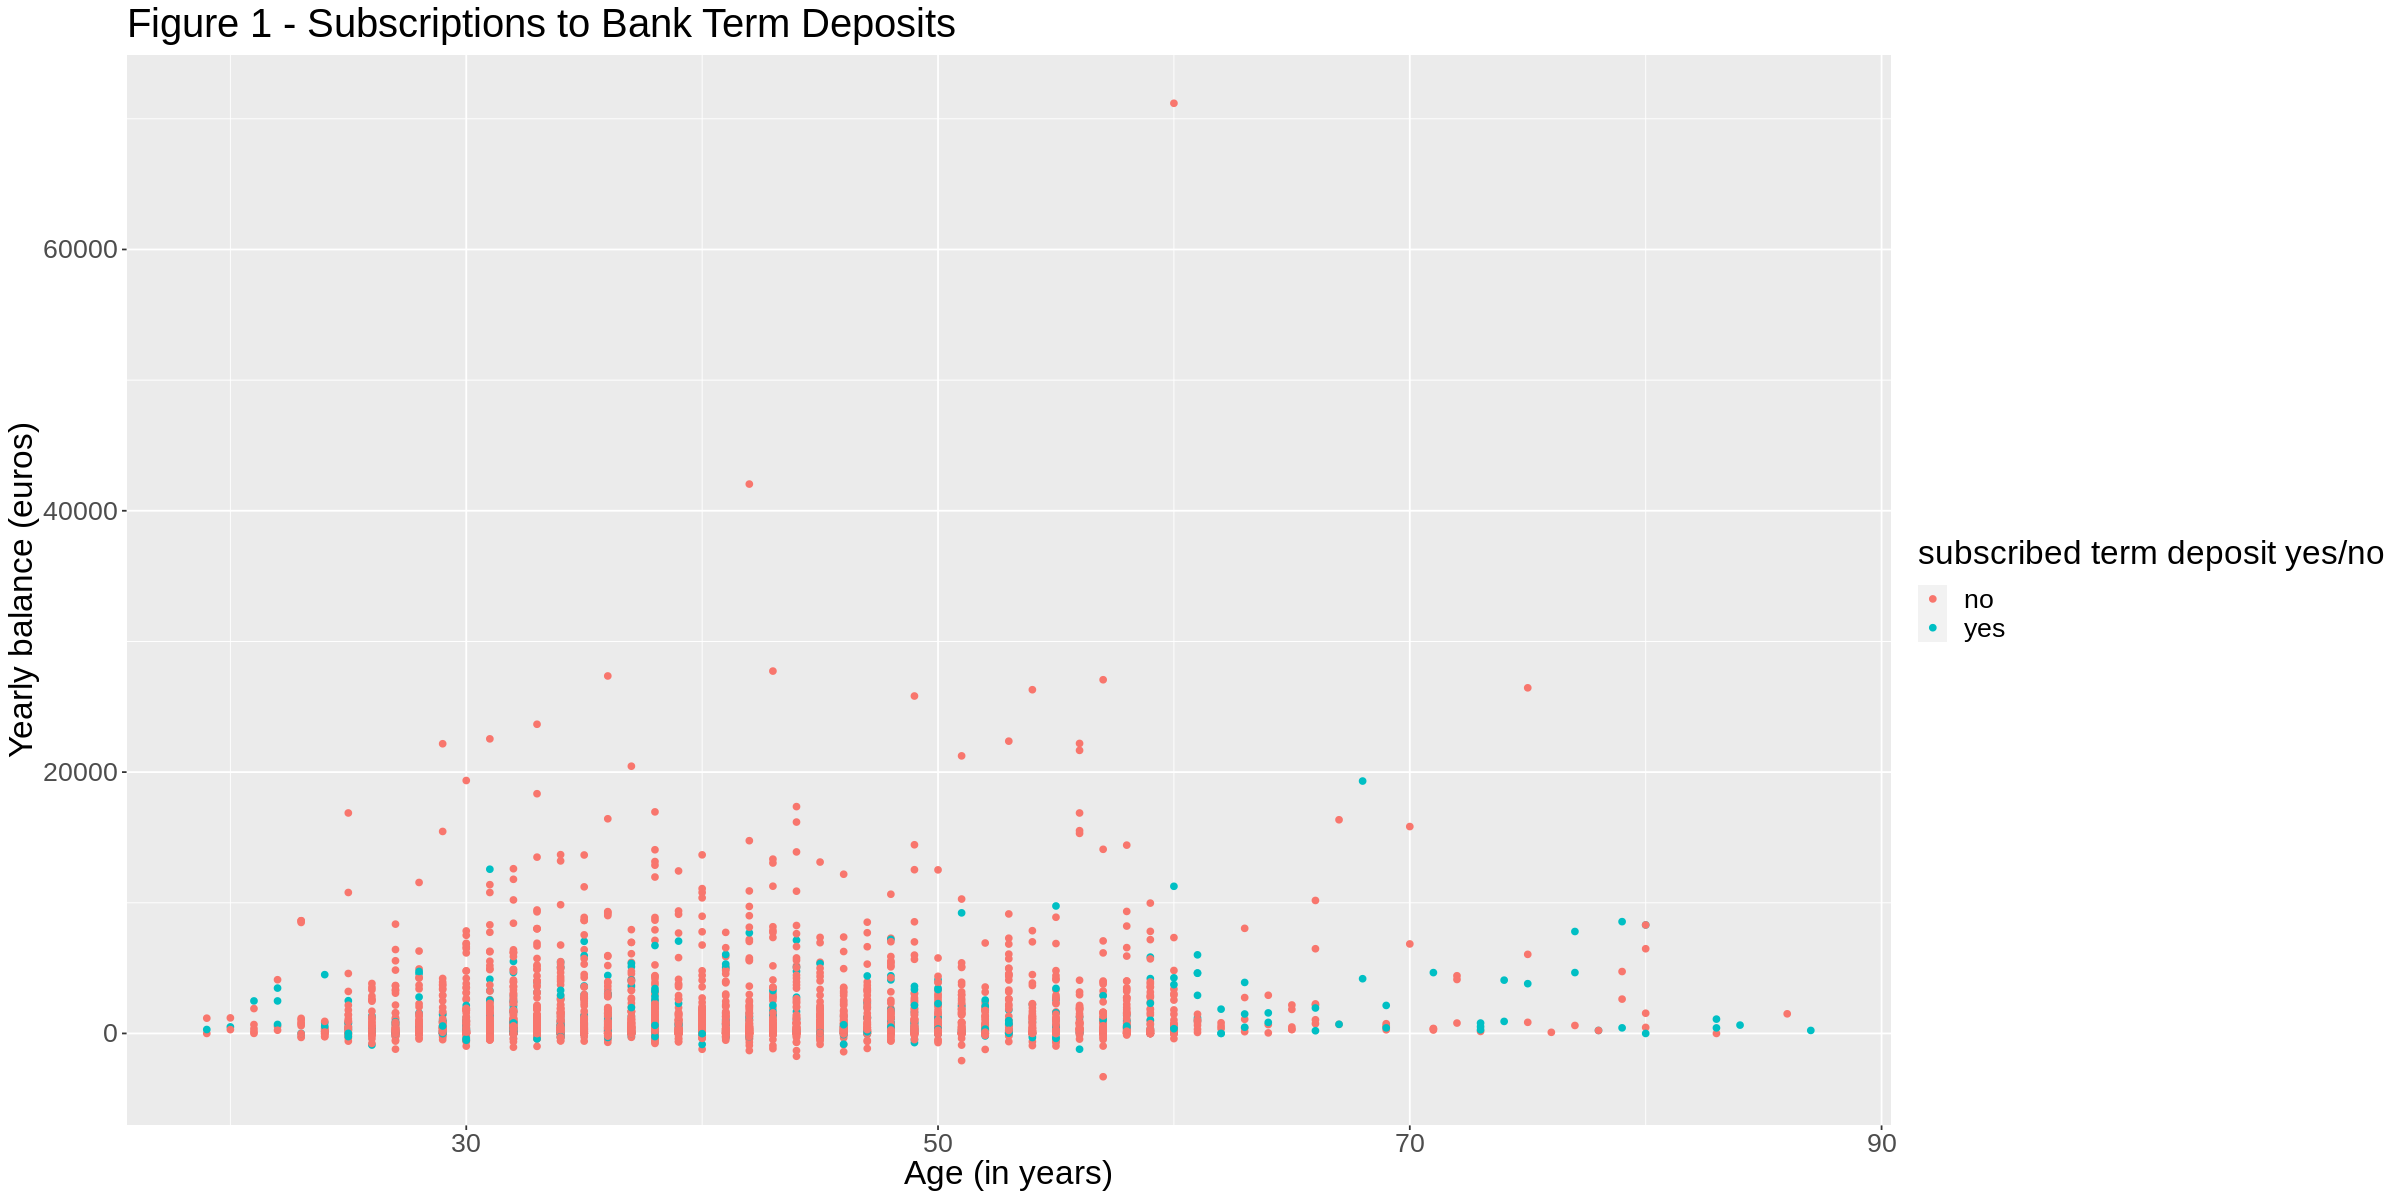

In [5]:
options(repr.plot.width = 20, repr.plot.height = 10)

age_vs_balance_plot <- bank_train %>%
    ggplot(aes(x = age, y = balance, color = y)) +
    geom_point() + 
    labs(x = "Age (in years)", y = "Yearly balance (euros)",
        colour = "subscribed term deposit yes/no") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 1 - Subscriptions to Bank Term Deposits")

age_vs_balance_plot

**Methods (continued)**<br/>
 As the unscale of the predictors could negatively impact the results, we will scale the data to mitigate these effects. So, we will scale the data and centered it using step_scale() and step_center(). After that, we will use prep function to finalize the recipe by using the data (bank_train) to compute anything necessary to run the recipe. After prep, we need to use bake function to apply the scaling and centering to the data. 
 
 Alos, there are lots of 'no' comparing to 'yes'. It will give imbalancing problem. Since classifiers like the k-nearest neighbor algorithm use the labels of nearby points to predict the label of a new point, if there are many more data points with one label overall, the algorithm is more likely to pick that label in general. We are going to upsampling rare y to rebalance the data.

**Table 3.0 - Scaling, Balancing, Centering Training Data**

First, we are doing scaling and centering all the given predictors.

In [6]:
bank_recipe_scaled <- recipe(y ~ ., data = bank_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

bank_recipe_scaled

scaled_bank <- bake(bank_recipe_scaled, bank_train)

head(scaled_bank)
tail(scaled_bank)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 3391 data points and no missing data.

Operations:

Scaling for age, balance [trained]
Centering for age, balance [trained]

age,balance,y
<dbl>,<dbl>,<fct>
-1.0509510,0.11054489,no
-0.5770196,-0.03014523,no
1.6978514,-0.46477145,no
-0.5770196,-0.22427828,no
-0.4822333,-0.36593423,no
-0.1978744,-0.41744549,no


age,balance,y
<dbl>,<dbl>,<fct>
0.7499885,-0.36110505,no
-0.2926607,-0.07682731,no
-0.8613784,-0.31249130,no
1.5082788,-1.53137640,no
1.5082788,-0.36979758,no
0.2760570,-0.09904154,no


Second, we are upsampling of y for balancing the data. In order to do this, we will add an oversampling step to the scaled_bank with the step_upsample function from the themis R package. Also we will use the group_by and summarize functions to see that our classes are now balanced.

In [13]:
bank_train2 <- recipe(y ~ ., data = scaled_bank) %>%
    step_normalize(age,balance) %>%
    step_upsample(y, over_ratio = 1, skip = FALSE) %>%
    prep() %>%
    bake(scaled_bank)

upsample_bank_train <- bank_train2 %>%
    group_by(y) %>%
    summarize(n = n())

head(bank_train2)
tail(bank_train2)

upsample_bank_train

dummy_recipe <- recipe(y ~ ., data = scaled_bank)

`summarise()` ungrouping output (override with `.groups` argument)



age,balance,y
<dbl>,<dbl>,<fct>
-1.0509510,0.11054489,no
-0.5770196,-0.03014523,no
1.6978514,-0.46477145,no
-0.5770196,-0.22427828,no
-0.4822333,-0.36593423,no
-0.1978744,-0.41744549,no


age,balance,y
<dbl>,<dbl>,<fct>
-1.6196687,0.9839826,yes
1.5082788,-0.1286605,yes
0.8447748,-0.3549881,yes
-0.7665921,-0.5987007,yes
1.4134925,-0.4502839,yes
-0.6718059,1.1726426,yes


y,n
<fct>,<int>
no,3000
yes,3000


Now we have upsampled and scaled dataset. So we want to show the plot of the scaled age and balance data with the factor y colored on every single points.

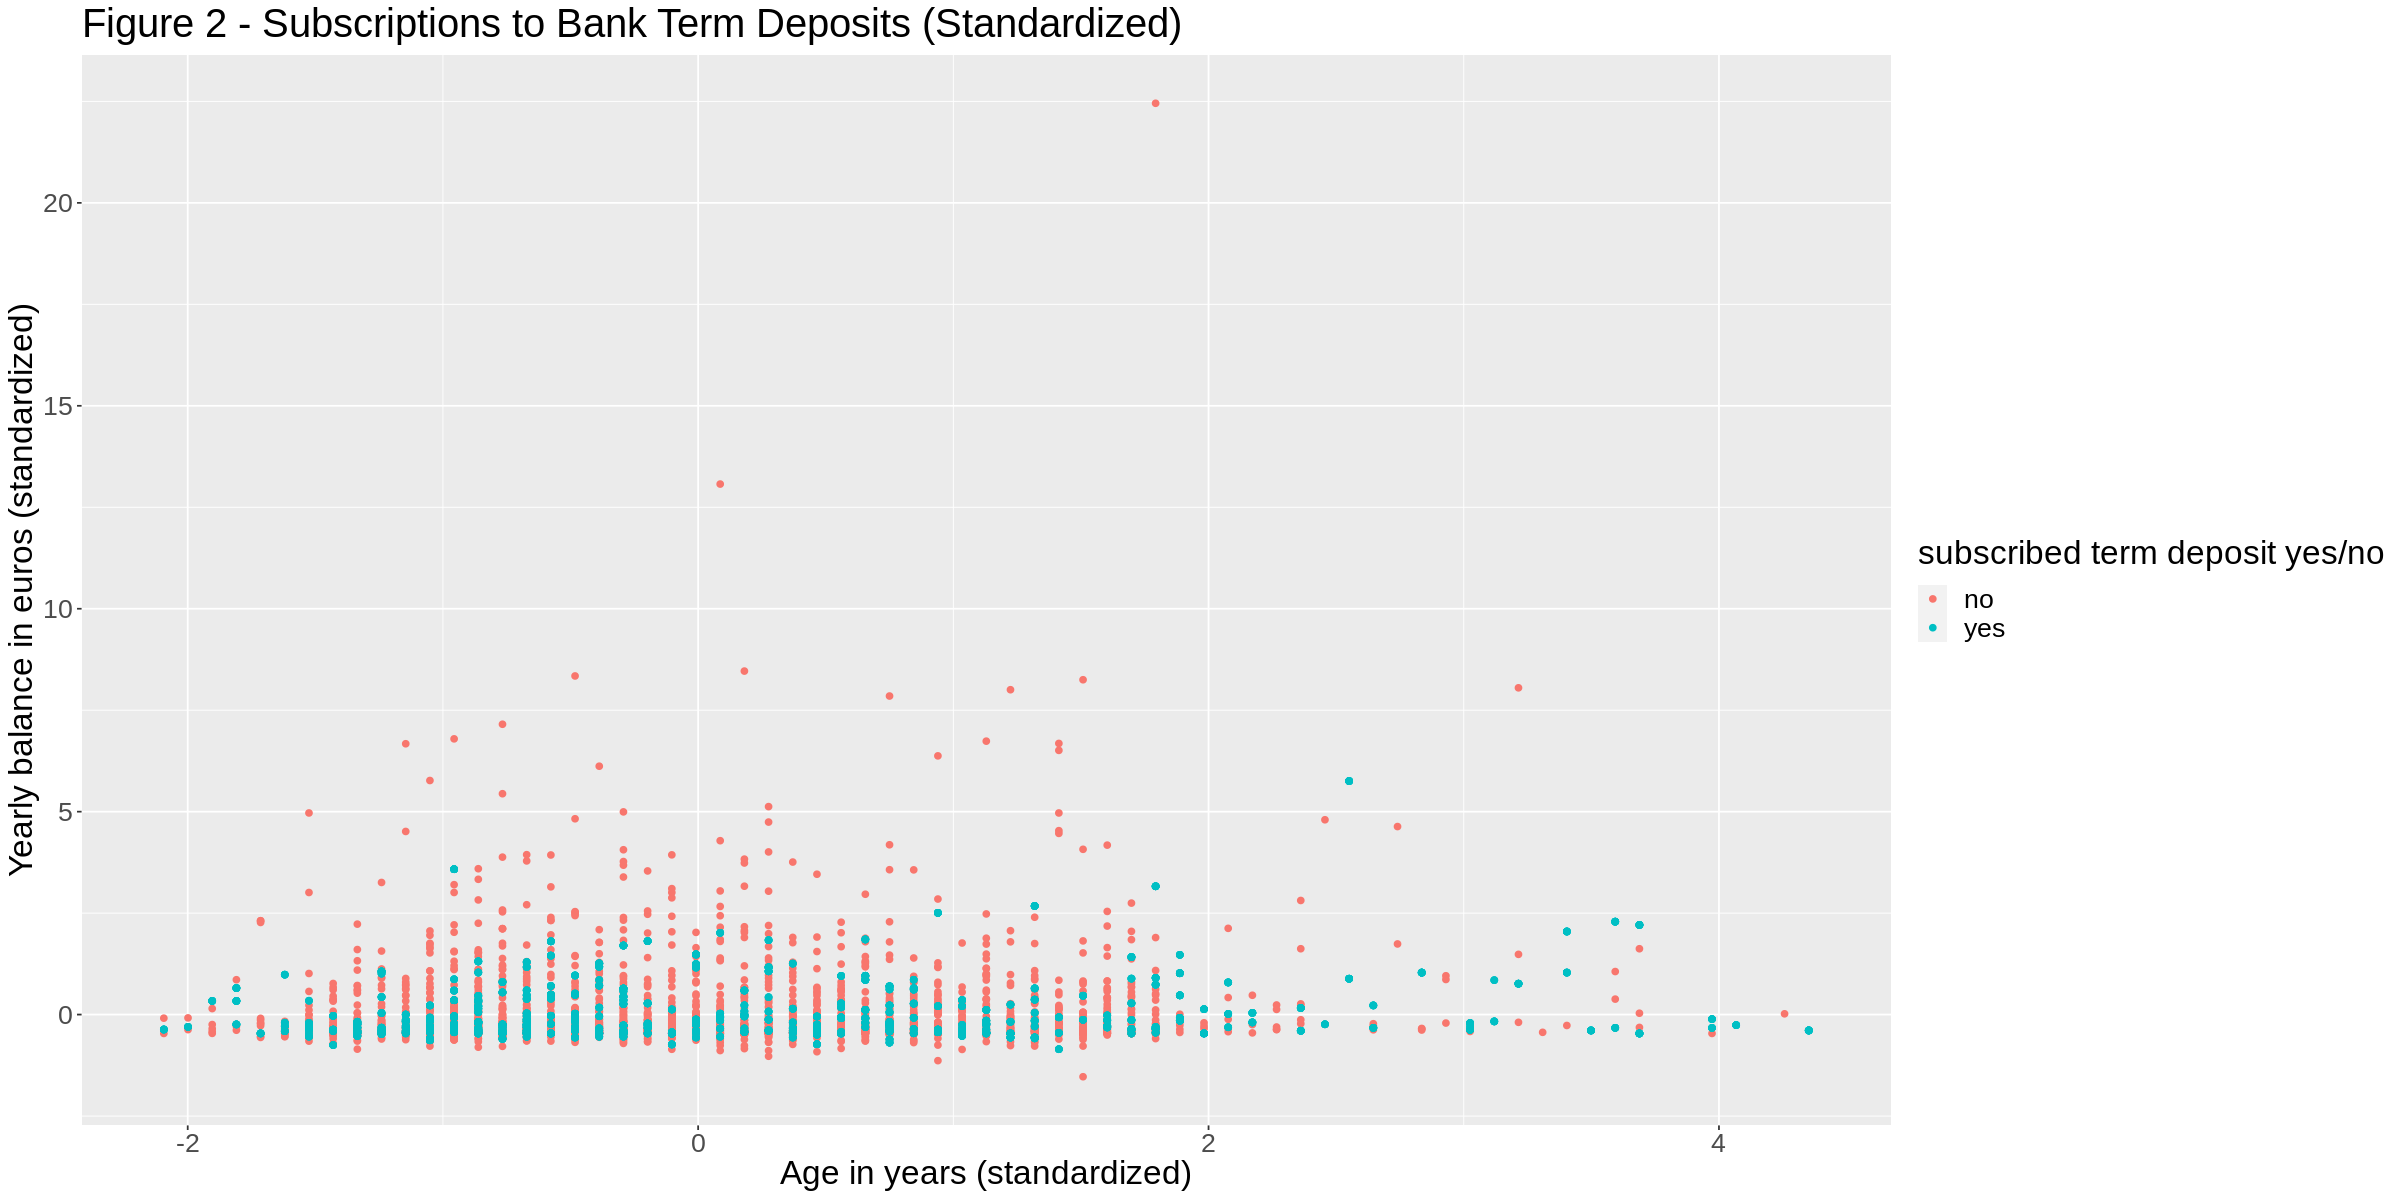

In [14]:
options(repr.plot.width = 20, repr.plot.height = 10) 

scaled_age_vs_balance_plot <- bank_train2 %>%
    ggplot(aes(x = age, y = balance, colour = y)) +
    geom_point() + 
    labs(x = "Age in years (standardized)", y = "Yearly balance in euros (standardized)",
        colour = "subscribed term deposit yes/no") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 2 - Subscriptions to Bank Term Deposits (Standardized)")

scaled_age_vs_balance_plot

**Table4.0- Accuray of K=10 Model**


!!!The K-nearest neighbors classifier was then created with the scaled training set (scaled_bank) and age and balance as predictors. The class labels for the test set were then predicted using the classifier. Then the accuracy of the classifier was assessed using the metrics function which was found to be 88.2%. A new plot of the Neighbors on the x-axis and the Accuracies on the y-axis was then created so that we could visualize the K that gives the best accuracy; it is K=12. 


!!!We create our K-nearest neighbour classifier with the training set.
Here we first randomly choose K=10 and run the process to make sure nothing is broken; we will perform cross-validation later and choose a better K value.

In [17]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
    set_engine("kknn") %>%
    set_mode("classification")

bank_fit <- workflow() %>%
    add_recipe(dummy_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)

bank_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~10, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1170746
Best kernel: rectangular
Best k: 10

!!! We predict y for the testing set using our model of K=10
!!!We calculate the accuracy of the model K=10, and the accuracy is 88.2%



In [18]:
bank_test_predictions <- predict(bank_fit, bank_test) %>%
    bind_cols(bank_test)
head(bank_test_predictions)

bank_prediction_accuracy <- bank_test_predictions %>%
    metrics(truth = y, estimate = .pred_class)%>%
    filter(.metric == "accuracy")%>%
    select(.estimate)%>%
    pull()
bank_prediction_accuracy

.pred_class,age,balance,y
<fct>,<dbl>,<dbl>,<fct>
no,33,4789,no
no,30,1476,no
no,56,784,no
no,59,42,no
no,49,1235,yes
no,23,363,no


[1] 0.8787611

**Table 5.0 - 5-Fold Cross Validation**

We would like to choose a better K value for our K-neighbour classification model, so we perform the cross-validation method on our training set.
We choose to perform 5-fold cross-validation because 10-fold is too time consuming.


Instead of specifying a specific K value we insert tune() to keep it as a changing parameter


Here we perform the workflow again with cross-validation method to calculate an accuracy for each K value in a reasonable range, and we pick the K value that gives best accuracy



In [19]:
bank_vfold <- vfold_cv(bank_train, v = 5, strata = y)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
knn_tune

knn_results <- workflow() %>%
      add_recipe(dummy_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = bank_vfold, grid = 10) %>%
      collect_metrics()
head(knn_results)

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8071383,5,0.003539232,Model01
1,roc_auc,binary,0.5205831,5,0.010769867,Model01
2,accuracy,binary,0.8077278,5,0.003160100,Model02
2,roc_auc,binary,0.5518584,5,0.007711508,Model02
4,accuracy,binary,0.8699523,5,0.002450541,Model03
4,roc_auc,binary,0.5708642,5,0.012662103,Model03


!!!Filter the accuracy from the .metric column

!!!Create a plot using the accuracies dataset with K value on the x-axis and estimated accuracy on the y-axis

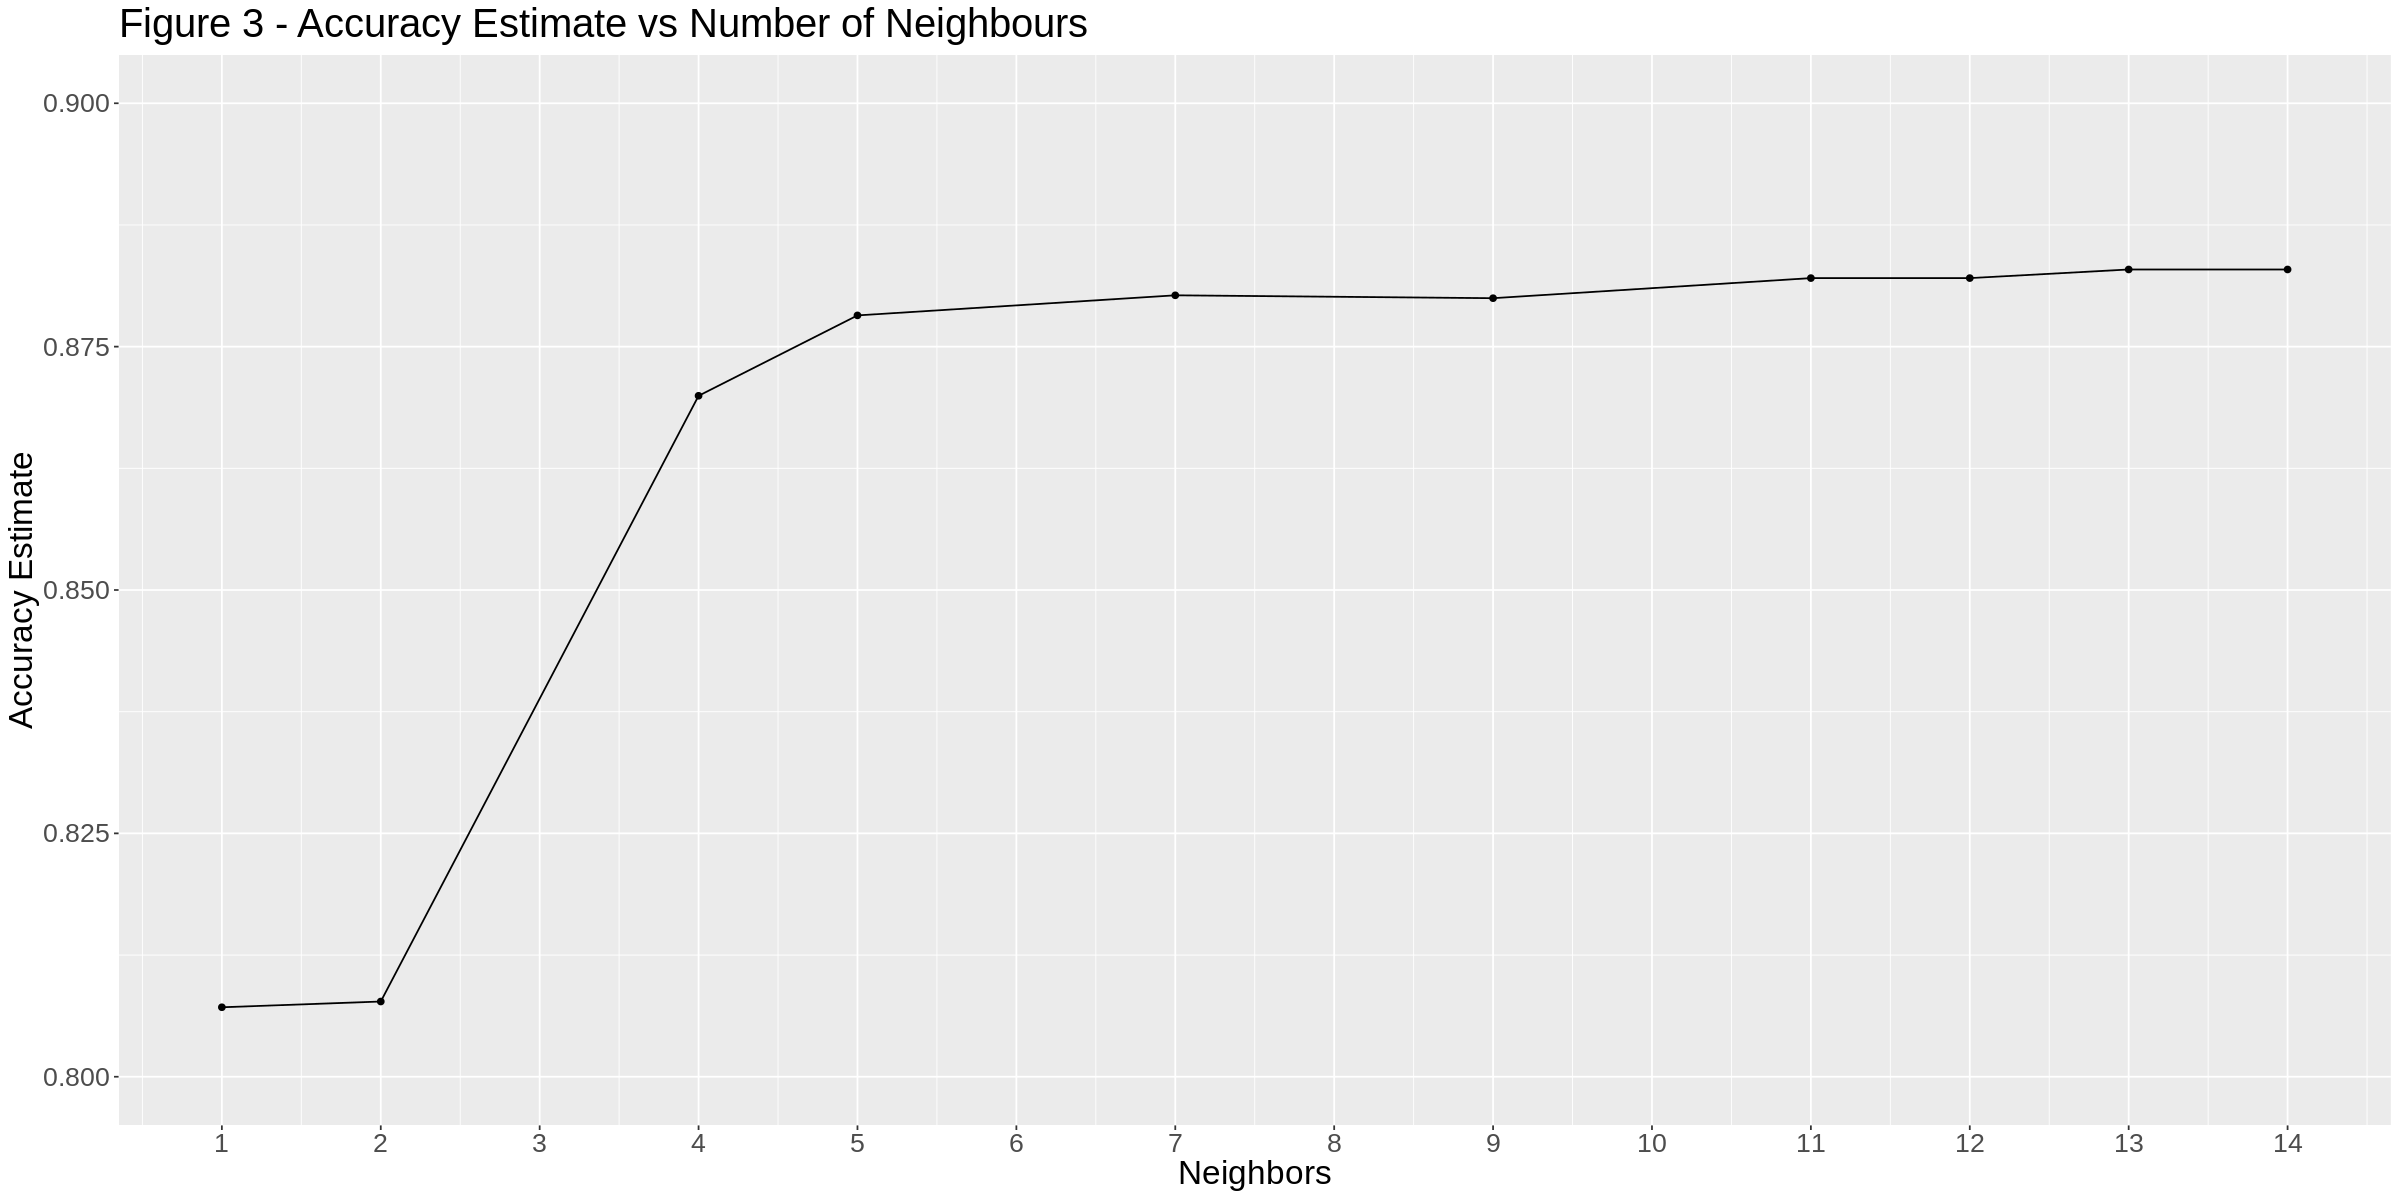

In [20]:
accuracies <- knn_results %>% 
      filter(.metric=="accuracy")

options(repr.plot.width = 20, repr.plot.height = 10) 
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.8, 0.9)) + # adjusting the y-axis
ggtitle("Figure 3 - Accuracy Estimate vs Number of Neighbours") +
theme(text = element_text(size = 20)) 
accuracy_versus_k

**Table 6.0 - Accuracy of Model**

!!!From the graph above, K=12 gives the best accuracy, so we perform the whole K-neighbours classification process with K=12 
The smallest RMSPE occurs at this K value, so we know that it is best

In [21]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
    set_engine("kknn") %>%
    set_mode("classification")

bank_fit <- workflow() %>%
    add_recipe(dummy_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)

bank_test_predictions <- predict(bank_fit, bank_test) %>%
    bind_cols(bank_test)
head(bank_test_predictions)

bank_prediction_accuracy <- bank_test_predictions %>%
    metrics(truth = y, estimate = .pred_class)
bank_prediction_accuracy


.pred_class,age,balance,y
<fct>,<dbl>,<dbl>,<fct>
no,33,4789,no
no,30,1476,no
no,56,784,no
no,59,42,no
no,49,1235,yes
no,23,363,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.87787611
kap,binary,0.03034448


!!! From bank_prediction_accuracy, our model of using age and balance to predict y have accuracy of 88.4%

**Results**<br/>
The K-nearest neighbors algorithm was repeated with K=12. The model we created to predict whether or not a new client will subscribe to a bank term deposit based on their age and bank balance was found to have an accuracy of 88.4%.

**Discussion: Expected Outcomes & Significance**

The main conclusion of our findings is that most people do not subscribe to a term deposit based on their age or balance. It is unexpected to see such a strong bias against subscribing throughout all of the data based on our two selected variables. However, studying this data provides insights of clientele behaviour to the bank. A company should always understand their consumer demographic and work accordingly to their actions and needs. Our results may cause the bank to reconsider its marketing strategies.

Perhaps there are other factors that cause clientele to subscribe to a term deposit, and this data provides a stepping stone to finding that specific demographic. If age and balance do not play a positive role, what does? The bank may work with these findings to figure out their target market to know who subscribes to term deposits and why they do it.

**References**

    Assistant, T. (n.d.). Piazza • Ask. answer. explore. whenever. DSCI 100 Piazza. Retrieved December 5, 2021, from https://www.piazza.com/. 
    
    [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014
    
    What's the difference between a term deposit and a savings account? Westpac. (n.d.). Retrieved December 6, 2021, from https://www.westpac.com.au/personal-banking/bank-accounts/term-deposit/savings-vs-term-deposit/. 
    
    Timbers, T.-A., Campbell, T., &amp; Lee, M. (2021, November 18). Data science: A first introduction. Chapter 10 Statistical inference. Retrieved December 7, 2021, from https://ubc-dsci.github.io/introduction-to-datascience/inference.html. 
   